In [59]:
import sympy as sp
import scipy.stats as stats
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
import statsmodels.nonparametric as nonparametric
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import interpolate
import time

class KDEDist(stats.rv_continuous):
    
    def __init__(self, kde, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._kde = kde
        self.make_discrete_cdf()
    
    def _pdf(self, x):
        return self._kde.pdf(x)
    
    def make_discrete_cdf(self):
        smallest = -4
        largest = 4
#         smallest = np.math.floor(self.ppf(0.0005))
#         largest = np.math.ceil(self.ppf(0.9995))
        vals = np.linspace(smallest, largest, num=100)
        self.vals = vals
        array = self.cdf(vals)
        self.discrete_cdf = array
    

class FastMean(stats.rv_continuous):
    
    def __init__(self, kde, discrete_cdf, vals, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.discrete_cdf = discrete_cdf
        self.vals = vals
        
    def _cdf(self, x):
        cdf = interpolate.interp1d(vals, self.discrete_cdf, bounds_error=False, fill_value="extrapolate")
        return cdf(x)
    
    def _ppf(self, y):
        ppf = interpolate.interp1d(self.discrete_cdf, vals, bounds_error=False, fill_value="extrapolate")
        return ppf(y)
    

In [60]:
data = stats.norm.rvs(size=500)
kde = stats.gaussian_kde(data)

def get_mean(kde):
    rv = KDEDist(kde)

    discrete_cdf = rv.discrete_cdf
    vals = rv.vals

    rv2 = FastMean(kde, discrete_cdf, vals)
    return rv2.mean()

get_mean(kde)

-0.02255643190149

In [61]:
def cdf(F, i, n):
    t = sp.Symbol('t')
    f = sp.Symbol('f')
    outside = np.math.factorial(n)/(np.math.factorial(i-1)*np.math.factorial(n-i))
    integrand = (t**(i-1)) * ((1-t)**(n-i))

    func = sp.integrate(integrand, (t,0,f))
    exp = outside*func-F
    try:
        ans = [s for s in sp.real_roots(exp) if 0<=s<=1][0]
    except:
        print(exp)
        print(sp.real_roots(exp))
        ans = 1
    
    
    return float(ans)

In [77]:
def smooth(ecdfs, p):
    def func(x):
        vals = [ecdf(x) for ecdf in ecdfs]
        tot = sum([np.exp(g*p) for g in vals if g >= 0])
        result = sum([g*np.exp(g*p) for g in vals if g >= 0])/tot
        return result
    return func

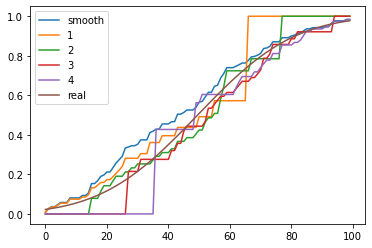

In [89]:
N = 4
rvs = [stats.norm.rvs(size=N) for _ in range(30)]
r_cdf = stats.norm.cdf

_ecdfs = [ECDF([sorted(l)[i-1] for l in rvs]) for i in range(1,N+1)]
smoothed = smooth(_ecdfs, 1)
smooth_ecdfs = [smoothed(x) for x in np.linspace(-2,2,num=100)]
plt.plot(smooth_ecdfs, label="smooth")


for i in range(1,N+1):
    il = [sorted(l)[i-1] for l in rvs]
    e_cdf = ECDF(il)
    ecdfs = [cdf(e_cdf(x), i, N) for x in np.linspace(-2,2,num=100)]
        
    plt.plot(ecdfs, label=i)

plt.plot()
                 
real_ecdfs = [r_cdf(x) for x in np.linspace(-2,2,num=100)]

plt.plot(real_ecdfs, label="real")
plt.legend()

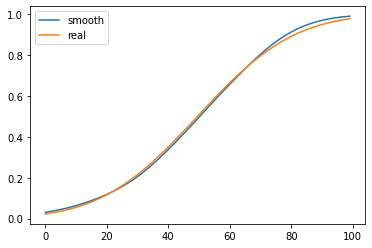

In [94]:
N = 4
rvs = [stats.norm.rvs(size=N) for _ in range(50)]
r_cdf = stats.norm.cdf

_ecdfs = [KDEDist(stats.gaussian_kde([sorted(l)[i-1] for l in rvs])).cdf for i in range(1,N+1)]
smoothed = smooth(_ecdfs, 0)
smooth_ecdfs = [smoothed(x) for x in np.linspace(-2,2,num=100)]
plt.plot(smooth_ecdfs, label="smooth")

# for i in range(1,N+1):
#     il = [sorted(l)[i-1] for l in rvs]
#     e_cdf = KDEDist(stats.gaussian_kde(il)).cdf
#     ecdfs = [cdf(e_cdf(x), i, N) for x in np.linspace(-2,2,num=100)]
        
#     plt.plot(ecdfs, label=i)
   
\
real_ecdfs = [r_cdf(x) for x in np.linspace(-2,2,num=100)]

plt.plot(real_ecdfs, label="real")
plt.legend()

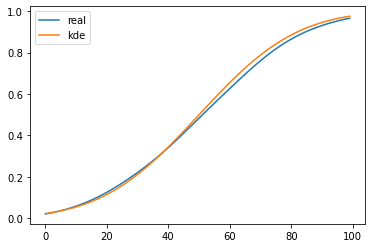

In [13]:
kde = KDEDist(stats.gaussian_kde(stats.norm.rvs(size=1000)))

cdf_vs = []
for j in range(-100,100,2):
    x = j/50
    cdf_vs.append(stats.norm.cdf(x))
    
cdf_vss = []
for j in range(-100,100,2):
    x = j/50
    cdf_vss.append(kde.cdf(x))
    
plt.plot(cdf_vss, label="real")
plt.plot(cdf_vs, label="kde")
plt.legend()

In [14]:
kde.mean()

0.043066077273968266

In [20]:
data = stats.norm.rvs(size=1000)
kde = stats.gaussian_kde(data)
rv = KDEDist(kde)

In [40]:
vals = np.linspace(-2,2,num=100)
discrete_cdf = rv.cdf(np.linspace(-2,2,num=100))

ppf = interpolate.interp1d(discrete_cdf, vals)

In [42]:
plt.plot(ppf(np.linspace(0,1,num=100)))

ValueError: A value in x_new is below the interpolation range.